In [12]:
%pylab inline
%config InlineBackend.figure_format='retina'

from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


Some $\LaTeX$ macros:
$$
\DeclareMathOperator{\erf}{erf}
$$

This simple example is what convinced my collaborators and myself to modify our treatment of selection effects; that eventually led to [Mandel, Farr & Gair (2018)](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1809.02063).  However, it turns out that we were not the first to realize these ideas; [Loredo (2004)](https://ui.adsabs.harvard.edu/#abs/2004AIPC..735..195L/abstract) is the first reference we have been able to find, but perhaps this is known by others as well.

## Setup

Suppose we are conducting a flux limited survey of standard candles in a Euclidean universe.  In some convenient units, the flux we receive from an object at distance $d$ is given by 
$$
F = \frac{5}{d^2} + \epsilon,
$$
where $\epsilon \sim N(0,1)$ is a random variable that represents detector noise.  Since we want a reliable survey, we decide to set a $5\sigma$ threshold for including an object in our catalog, so when 
$$
F > 5,
$$
we decide that we have *detected* a source.  Note that this means that the detection efficiency at $d = 1$ is 50% (since as long as $\epsilon > 0$---which occurs with probability 50%---we have $F > 5$).  

In fact, the probability that we will detect an object at distance $d$ is given by 
$$
P_\mathrm{det} \left( d \right) = 1 - \Phi\left( 5 - \frac{5}{d^2} \right),
$$
where $\Phi(x)$ is the CDF of the unit Normal distribution,
$$
\Phi(x) = \frac{1}{2} \left( 1 + \erf\left( \frac{x}{\sqrt{2}} \right) \right).
$$
This probability is shown below:

/Users/wfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0,0.5,'$P_\\mathrm{det}(d)$')

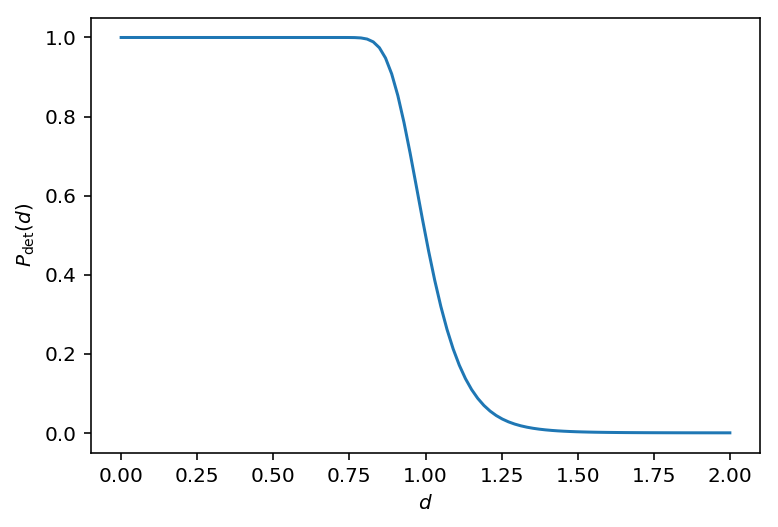

In [5]:
def Pdet(d):
    x = 5 - 5/d**2
    return 1 - 0.5*(1.0 + erf(x/sqrt(2)))

ds = linspace(0, 2, 100)
plot(ds, Pdet(ds))
xlabel(r'$d$')
ylabel(r'$P_\mathrm{det}(d)$')

Let's generate a catalog of sources, and their observed fluxes.

In [41]:
N = 10000
dMax = 2

true_ds = dMax*cbrt(rand(N))
obs_fluxes = 5.0/true_ds**2 + randn(N)

selected = obs_fluxes > 5

flux_catalog = obs_fluxes[selected]

Here is the observed distribution of flux:

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


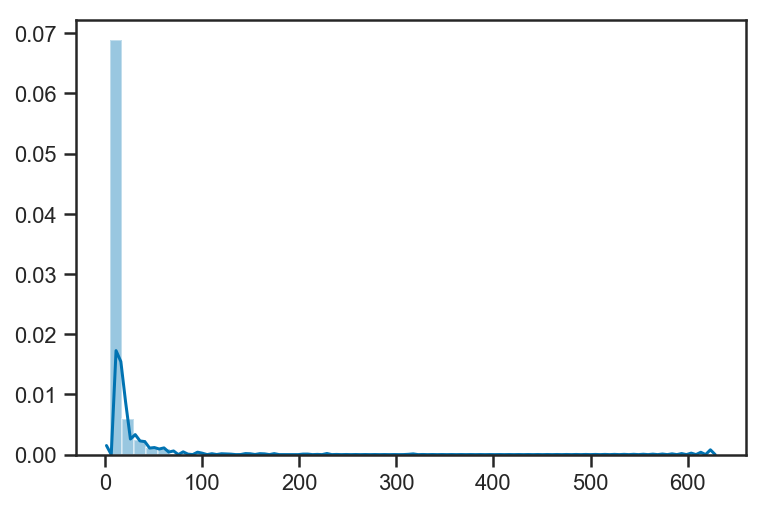

In [42]:
sns.distplot(flux_catalog)

We now want to infer the spatial distribution of sources using this catalog; suppose we did not know that the sources are uniform in volume, but instead want to fit a power law to the observations, out to some maximum distance (here we will use $d_\mathrm{max} = 2$, which is pretty far outside the detectable region of our survey):
$$
p\left( d \right) = \frac{\left(\alpha + 1\right) d^\alpha}{d_\mathrm{max}^{\alpha + 1}}.
$$

We begin by drawing samples from the likelihood for distance for each event; 100 samples should do it.  The likelihood is set by our noise assumptions.  
$$
p\left( F \mid d \right) = \frac{1}{\sqrt{2\pi}} \exp\left[ - \frac{\left( F - 5/d^2 \right)^2}{2} \right]
$$

In [43]:
def sample_likelihood(Fobs, N):
    def l(d):
        return exp(-(Fobs-5/d**2)**2/2)
    
    dest = sqrt(5/Fobs)
    ds = logspace(log10(dest/10), log10(dest*10), 1000)
    ls = l(ds)
    
    # Cumulative dist
    cls = cumtrapz(ls, ds, initial=0)
    cls /= cls[-1] # Normalize
    
    icdf = interp1d(cls, ds)
    
    return icdf(rand(N))

In [44]:
dsamples = array([sample_likelihood(F, 100) for F in flux_catalog])

Here are the likelihoods in distance:

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.3650459213893016, 2, 0.0, 1551.9096757558425)

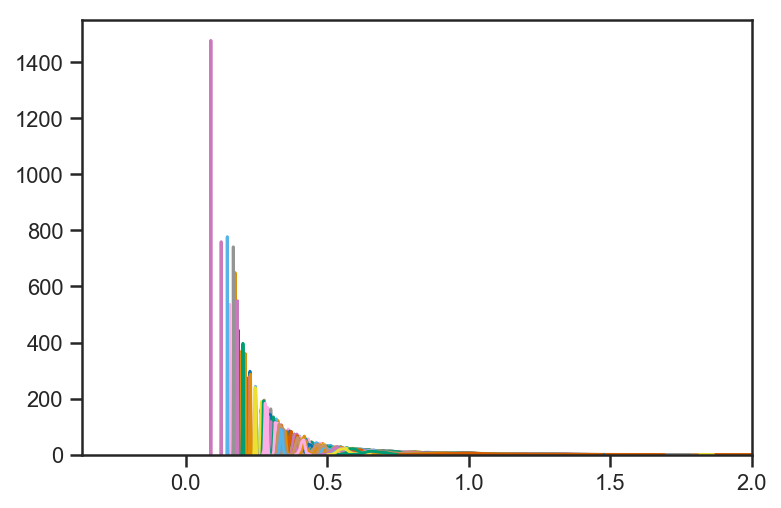

In [45]:
for d in dsamples:
    sns.kdeplot(d)
axis(xmax=2)

## What Not To Do

It is simple, but incorrect, to convince yourself that the correct "population" prior to impose on the distances to infer the power-law index of the population is the "detected" population of distance---the product of the population distribution and the detection probability at each distance:
$$
p_\mathrm{det}\left( d \mid \alpha \right) \propto \frac{\left( \alpha + 1 \right) d^\alpha}{d_\mathrm{max}^{\alpha+1}} P_\mathrm{det}(d)
$$

In [46]:
def p_pop(d, alpha):
    return (alpha+1)*d**alpha/dMax**(alpha+1)

def wrong_prior_norm(alpha):
    ds = linspace(0, dMax, 1000)
    ps = p_pop(ds, alpha)*Pdet(ds)
    
    return trapz(ps, ds)

def wrong_prior_unnormalized(d, alpha):
    return p_pop(d,alpha)*Pdet(d)

If we try to analyze the results we have above using this prior to fit for alpha, we obtain a biased result.  Recall that the way to do this hierarchical fitting is to apply the population distribution to each event as a "prior," and then integrate out the degree of freedom---the distance---for that event:
$$
p\left( \alpha \mid \left\{ F_i | i = 1, \ldots, N \right\} \right) \propto \prod_{i} \int \mathrm{d} d_i \, p\left( F_i \mid d_i \right) p_\mathrm{det} \left( d_i \mid \alpha \right) \propto \prod_{i} \left\langle p_\mathrm{det} \left( d_{ij} \mid \alpha \right) \right\rangle_{j},
$$
where the averaging is done over the distance samples, $d_{ij}$, drawn from the likelihood for event $i$.

In [51]:
def wrong_logposterior_alpha(alpha):
    n = wrong_prior_norm(alpha)
    
    logprob = 0.0
    for ds in dsamples:
        prob = mean(wrong_prior_unnormalized(ds, alpha))/n
        logprob += log(prob)
    
    return logprob

In [57]:
alphas = linspace(1.5, 2.5, 100)
logps = [wrong_logposterior_alpha(a) for a in alphas]
ps = exp(logps)
ps /= trapz(ps, alphas)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


This shows a significant bias in the recovery of $\alpha$ (which should be 2 for a volumetric distribution):

Text(0,0.5,'$p\\left( \\alpha \\right)$')

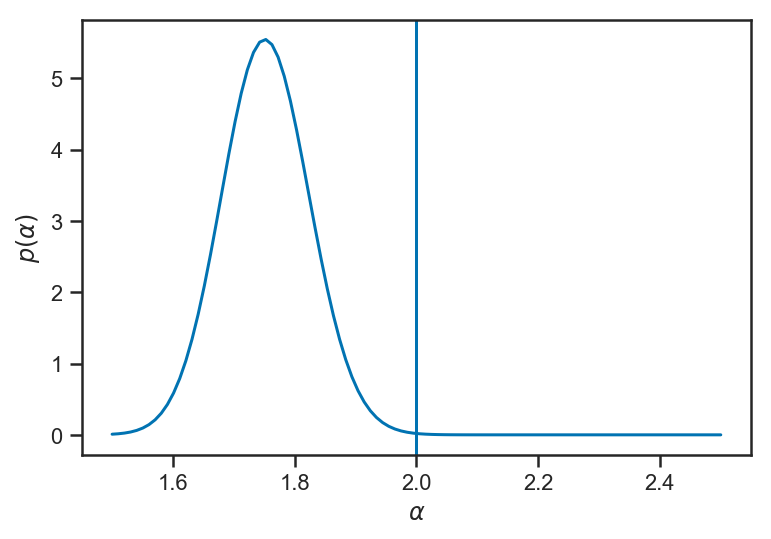

In [58]:
plot(alphas, ps)
axvline(2)
xlabel(r'$\alpha$')
ylabel(r'$p\left( \alpha \right)$')

What went wrong?  Turns out that the factor of $P_\mathrm{det}(d)$ is not correct!  The detection / non-detection decision is made on the *data* (here the fluxes), not on the parameters (distances---which we do not know).  So $P_\mathrm{det}$ for any of the events we observe is, by definition, 1!  Putting an additional factor of $P_\mathrm{det}(d)$ into the prior introduces a bias in our estimate of the distance for each event, and that leads to the bias in the population recovery.

## What To Do

For the full explanation, see [Mandel, Farr & Gair (2018)](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1809.02063).  That text also discusses (and derives) the correct procedure to use when we want to fit *number densities*, $\mathrm{d} N/ \mathrm{d} d$, which reduces to this procedure if we subsequently ignore the normalization and consider only the *shape* of the number density.  Here we summarize.

We can resolve this problem by noting that the joint distribution for flux and distance conditioned on the parameter $\alpha$  forms a "likelihood" for $\alpha$ in each measurement:
$$
p\left( F, d \mid \alpha \right) = p\left( F \mid d \right) p\left( d \mid \alpha \right).
$$
But this distribution, as written above, is not properly normalized under the assumption that we only consider *detected* data, $F>5$.  We can introduce a normalization factor 
$$
p\left( F, d \mid \alpha \right) = \frac{p\left( F \mid d \right) p\left( d \mid \alpha \right)}{\beta\left( \alpha \right)},
$$
where 
$$
\beta\left(\alpha \right) \equiv \int_{F > 5} \mathrm{d} F \, \mathrm{d} d \, p\left( F \mid d \right) p\left( d \mid \alpha \right) = \int \mathrm{d} d \, P_\mathrm{det} (d) p\left( d \mid \alpha \right).
$$
$\beta$ is the fraction of the *population* defined by $\alpha$ that is observable.  

If we now do the standard hierachical inference:
$$
p\left( \alpha \mid \left\{ F_i | i = 1, \ldots, N \right\} \right) \propto \prod_{i} \int \mathrm{d} d_i \, \frac{p\left( F_i \mid d_i \right) p\left( d \mid \alpha \right)}{\beta\left(\alpha\right)} \propto \prod_{i} \frac{\left\langle p\left( d_{ij} \mid \alpha \right) \right\rangle_{j}}{\beta\left(\alpha\right)}
$$
applying the population prior to each event and normalizing over all detectable data via $\beta$, we obtain unbiased inferences:

In [60]:
def beta(alpha):
    ds = linspace(0, dMax, 1000)
    ps = Pdet(ds)*p_pop(ds, alpha)
    
    return trapz(ps, ds)

def logposterior_alpha(alpha):
    b = beta(alpha)
    
    logprob = 0.0
    for d in dsamples:
        p = mean(p_pop(d, alpha))/b
        logprob += log(p)
    
    return logprob

In [61]:
logps = array([logposterior_alpha(a) for a in alphas])
ps = exp(logps)
ps /= trapz(ps, alphas)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0,0.5,'$p\\left( \\alpha \\right)$')

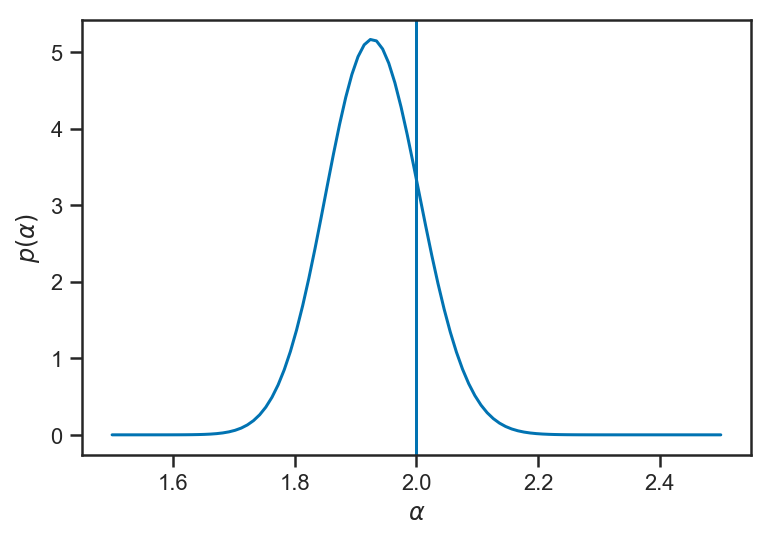

In [64]:
plot(alphas, ps)
axvline(2)
xlabel(r'$\alpha$')
ylabel(r'$p\left( \alpha \right)$')

Remember *selection is (almost always) on the data, not the parameters, so don't introduce the detection probability into the prior*!

(There are a couple of exceptions.  In [Farr & Mandel (2018)](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1807.09772) there was a component of the "selection" function that required that the stellar lifetime is long enough that it is still hydrogen burning at the time of observation, which introduced a parameter-dependent selection.  Maggie Lieu has also pointed out that objects that are selected based on one data set---e.g. X-ray selected clusters---and then analyzed on the basis of another data set---e.g. weak-lensing cluster mass estimates---effectively introduces a parameter-dependent selection function.  But these are not the typical case!)